In [1]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)
from torch.utils.data import Subset

from astropy.io import fits 
import sparsetools as sp
import imtools as im #in the STiC example folder
import matplotlib.pyplot as plt 
from IPython.display import display, HTML


display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# Load the input data:

data = sp.profile("/home/milic/data/sst_sunspot/final_mosaic_NaICaII_newcalib_092244_NNtraining.nc").dat[0,] 
data.shape

profile::setsize: nx=464, ny=280, nw=21, ns=4, nt=1
['profiles' 'wav' 'weights' 'pixel_weights']
profile::read: [profiles][wav][weights][pixel_weights]


(280, 464, 21, 4)

In [3]:
NX, NY, NL, NS = data.shape

In [4]:
data_to_invert = data[:,:,:,0].reshape(NX*NY,NL)

In [5]:
# Hard-coded normalization for the spectra (can this be done better, but without passing the dataitself, perhaps modify the model?)
dimax = 1.7161694765090942 
dimin = 0.10283385217189789

In [6]:
data_to_invert[:,:] = (data_to_invert[:,:] - dimin) / (dimax - dimin)

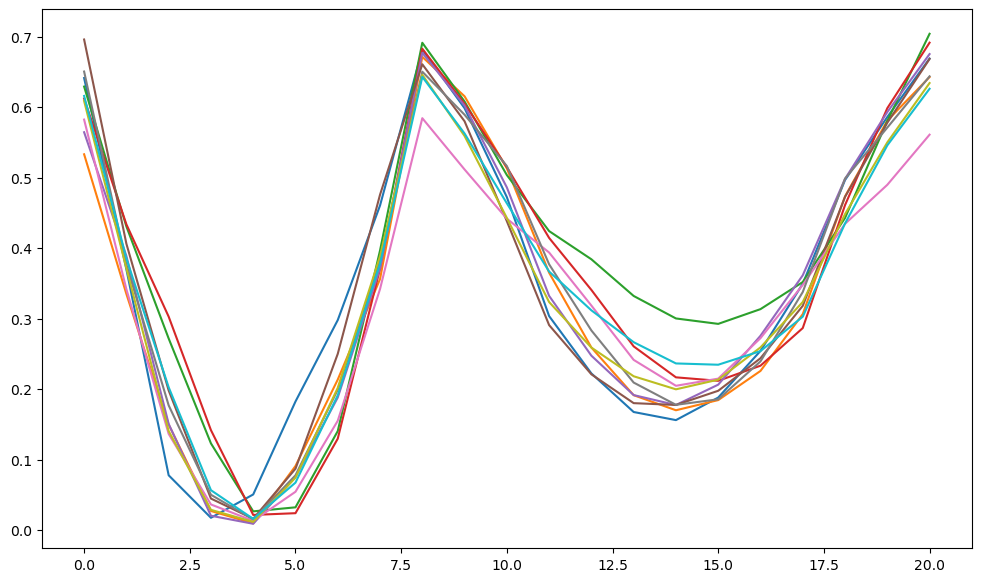

In [7]:
# Check the looks:

plt.figure(figsize=[12,7])
for i in range(0,10):
    plt.plot(data_to_invert[i*1000])

In [8]:
# We are going to make a dense autoencoder here:


class testdnn(nn.Module):
    def __init__(self, inputsize, outputsize):
        super(testdnn, self).__init__()
        self.linear1 = nn.Linear(inputsize,16)
        self.linear1a = nn.Linear(16,16)
        self.linear2 = nn.Linear(16,16)
        self.linear2a = nn.Linear(16,8)
        self.linear3 = nn.Linear(8,8)
        self.linear4 = nn.Linear(8,16)
        self.linear5 = nn.Linear(16,16)
        self.linear6 = nn.Linear(16,outputsize)
        
        
        self.activation = nn.ReLU()
        self.activationS = nn.Sigmoid()
        
        
        self.dropout05 = nn.Dropout(0.5)
        
        
    def forward(self, data_in):
        
        x = self.linear1(data_in)
        x = self.activationS(x)
        x = self.linear1a(x)
        x = self.activationS(x)
        x = self.linear2(x)
        x = self.activationS(x)
        #x = self.linear2a(x)
        #x = self.activationS(x)
        #x = self.linear3(x)
        #x = self.activationS(x)
        #x = self.linear4(x)
        #x = self.activationS(x)
        x = self.linear5(x)
        x = self.activationS(x)
        data_out = self.linear6(x)
        #data_out = self.activationS(x)
            
        return data_out
    
def make_model(cudaoption, inputsize, outputsize):
    
    model = testdnn(inputsize, outputsize)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model   

def model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output

## Let's make a function to train:

def compilefit(model, data_in, data_out, data_val_in, data_val_out, nepochs, criterion, cudaoption, lri, output_interval, batch, weight_decayi, w):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri, weight_decay = weight_decayi)
    loss_fn = nn.MSELoss()
    loss_val_fn = nn.MSELoss()
    
    if cudaoption:
        data_in = data_in.to(device)
        data_out = data_out.to(device)
        data_val_in = data_val_in.to(device)
        data_val_out = data_val_out.to(device)
        
        w = w.to(device)
        
        
    performance = np.zeros([2,nepochs])
                
    for i in range(0,nepochs):
            
        optimizer.zero_grad()
        out = model.forward(data_in)
        loss = loss_fn(data_out, out)
        loss.backward()
        optimizer.step()
        performance[0,i] = loss.item()
        
        # Validation:
        out_val = model.forward(data_val_in)
        loss_val = loss_val_fn(out_val, data_val_out)
        performance[1,i] = loss_val.item()
        
            
        if (i+1)%int(output_interval)==0: print(f' It : {i+1:3d} - residual std : {np.sqrt(loss.item()):.6f} - val std : {np.sqrt(loss_val.item()):.6f}')
    return performance

In [9]:
cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)

[INFO] Cuda: True
[INFO] Cuda device: cuda:0


In [11]:
dnn = torch.load("sstinv_full_take_1.pt")

In [12]:
data_to_invert = torch.from_numpy(data_to_invert.astype('float32'))

In [13]:
# Invert:

result = model_predict(dnn,data_to_invert,cudaoption)

In [14]:
# Test:

result = result.detach().numpy()
result.shape

(129920, 13)

In [15]:
result = result.reshape(NX,NY,13)

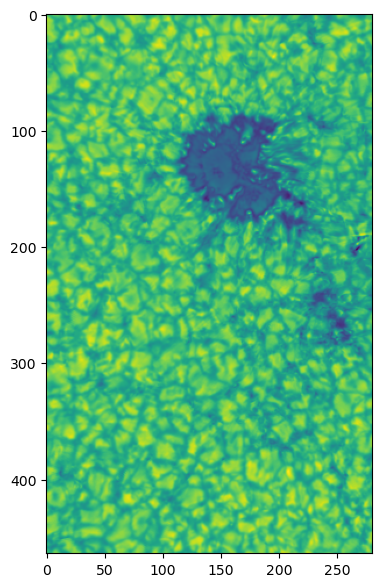

In [17]:
i = 4
plt.figure(figsize=[12,7])
plt.imshow(result[:,:,i].T)

In [54]:
# Denormalize result and compare the with the original inversion:

In [22]:
# You need to look these up in the inversion notebook, but I c/p ed them here
#3100.0 7952.3203125
#-20.0 19.09949
#0.0 12.70172375

min_t = 3100.0 
max_t = 7952.3203125
min_vlos = -20.0E5
max_vlos = 19.09949E5
min_vturb = 0.0
max_vturb = 12.70172375

In [23]:
dnn_inverted_temp = result[:,:,:5]
dnn_inverted_vlos = result[:,:,5:10]
dnn_inverted_vturb = result[:,:,:10:13]

In [24]:
dnn_inverted_temp = dnn_inverted_temp  * (max_t - min_t) + min_t
dnn_inverted_vlos = dnn_inverted_vlos * (max_vlos - min_vlos) +  min_vlos
dnn_inverted_vturb = dnn_inverted_vturb * (max_vturb - min_vturb)  + min_vturb

In [21]:
# Compare with the existing inversions:

#imodel = sp.model("D:/QS_inversions/atmosout_IBIS_data_inversion_patch_148_c2.nc")

model::read: Error, file D:/QS_inversions/atmosout_IBIS_data_inversion_patch_148_c2.nc not found


In [59]:
#inodes_temp = np.array([16,21,26,31,38,46,56,64])
#inodes_vlos = np.array([16,26,36,46,56])
#inodes_vturb = np.array([16,26,36,46,56])

In [60]:
#og_temp = imodel.temp[0,:,:,inodes_temp].transpose(1,2,0)
#og_vlos = imodel.vlos[0,:,:,inodes_vlos].transpose(1,2,0)
#og_vtur = imodel.vturb[0,:,:,inodes_vturb].transpose(1,2,0)

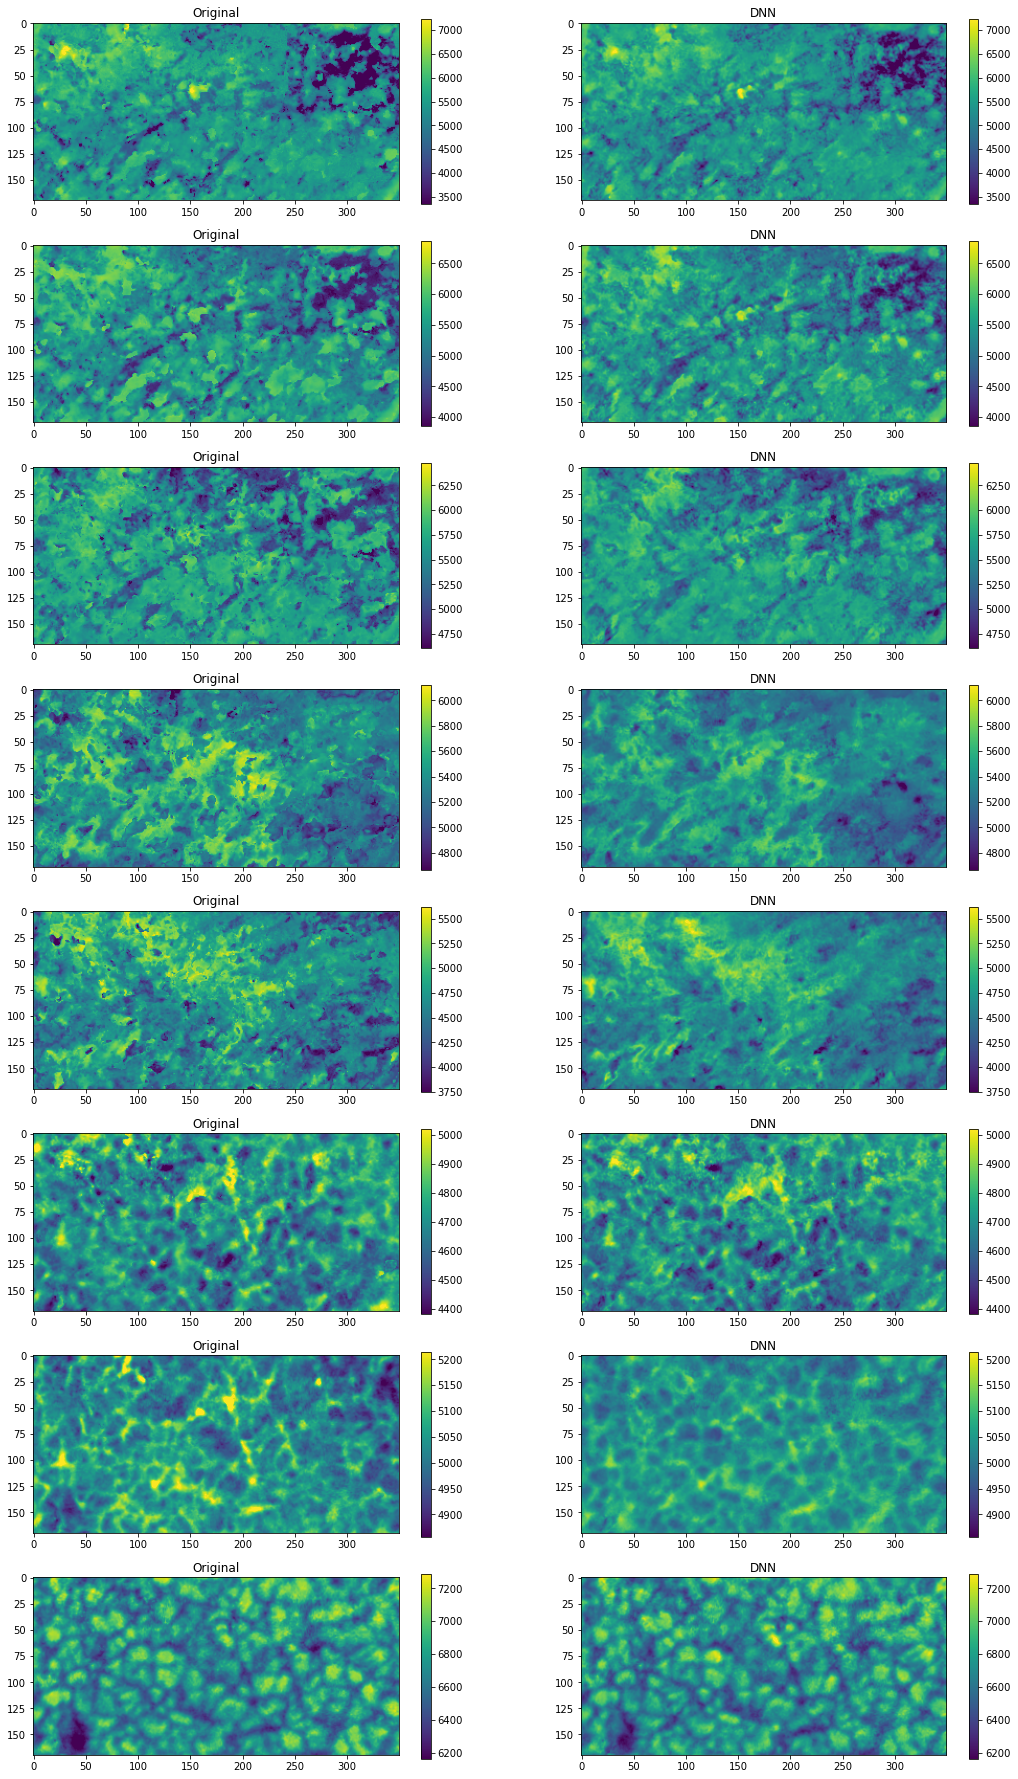

In [73]:
# Comparison: 


#plt.figure(figsize=[18,32])
#for i in range(0,8):
#    plt.subplot(8,2,2*i+1)
#    v_min = np.mean(og_temp[:,:,i]) - 3*np.std(og_temp[:,:,i])
#    v_max = np.mean(og_temp[:,:,i]) + 3*np.std(og_temp[:,:,i])
#    plt.imshow(og_temp[:,:,i].T, vmin=v_min, vmax=v_max)
#    plt.title("Original")
#    plt.colorbar()
#    plt.subplot(8,2,2*i+2)
#    plt.imshow(dnn_inverted_temp[:,:,i].T, vmin=v_min, vmax=v_max)
#    plt.title("DNN")
#    plt.colorbar()